# Problem set 2

## Team
Please write here your names and team number.

* Team name:
* Team members:

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [ ]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 16108 with label: 6


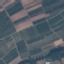

In [ ]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

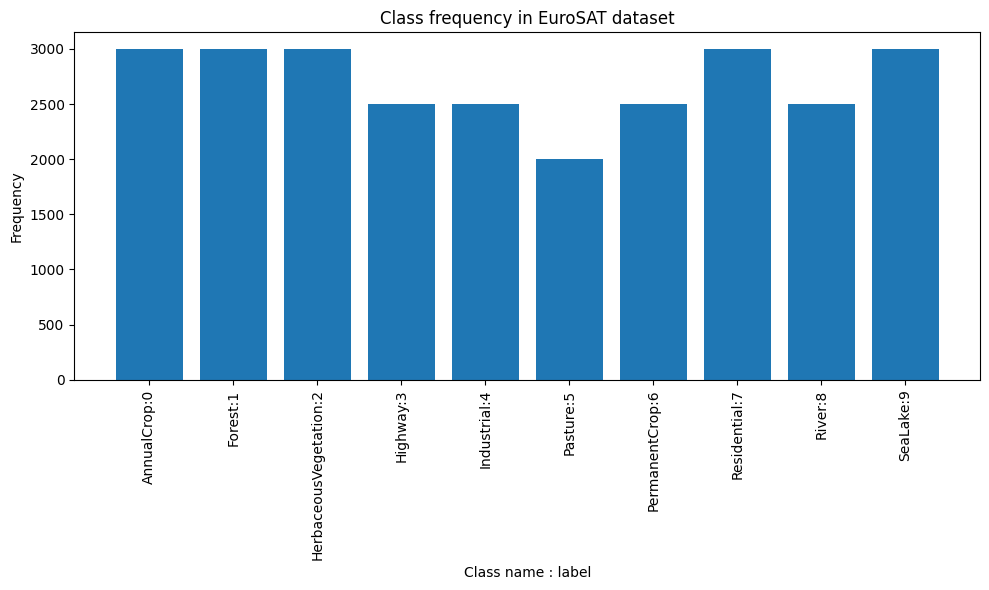

In [ ]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

def rotate_picture(picture, rotation):
    '''
    Rotates a picture by 90, 180, 270 or 360 degrees.
    Returns an error if rotation is not allowed.
    '''
    allowed = [90, 180, 270, 360]
    if rotation not in allowed:
        raise ValueError(f"Rotation of {rotation}° not allowed. Choose from {allowed}.")

    k = rotation // 90        # number of times to rotate by 90°
    rotated = np.rot90(np.array(picture), k)   # convert to np.array in case it's PIL Image
    return rotated


def plot_histogram(data):
    '''
    Plots the frequency of each class in the EuroSAT dataset.
    Shows both class name and label on x-axis.
    '''
    # extract all labels
    labels = [label for _, label in data]
    # count occurrences manually (no Counter)
    counts = np.zeros(len(data.classes), dtype=int)
    for l in labels:
        counts[l] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(counts)), counts)
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels([f"{data.classes[i]}:{i}" for i in range(len(counts))],
                       rotation=90)
    ax.set_xlabel("Class name : label")
    ax.set_ylabel("Frequency")
    ax.set_title("Class frequency in EuroSAT dataset")
    plt.tight_layout()
    return fig, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)
fig, ax = plot_histogram(data)
fig.show()

Text(0.5, 1.0, 'Rotated by 360°')

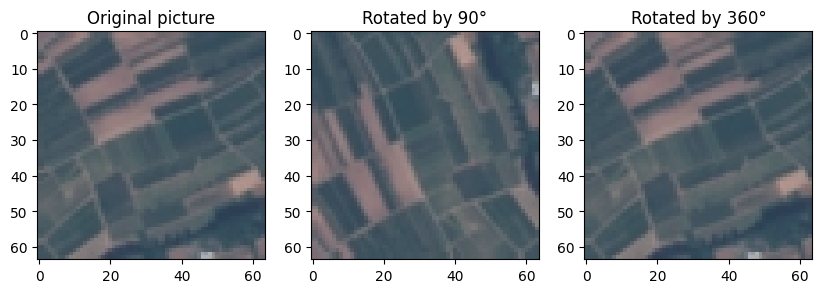

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [ ]:
import random
from torchvision import transforms

class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data: Dataset,
                 length: int,
                 shares: list,
                 device=None,
                 seed=42):
        self.original_data = original_data
        self.length = length
        assert sum(shares) == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label

    def _create_rotated_dataset(self):
        """Creates a dataset of randomly rotated pictures with proper class proportions."""
        np.random.seed(self.seed)
        random.seed(self.seed)

        # Calculate number of samples per class based on shares
        samples_per_class = [int(self.length * s) for s in self.shares]

        # Adjust for rounding errors
        remainder = self.length - sum(samples_per_class)
        if remainder > 0:
            largest_shares = np.argsort(self.shares)[-remainder:]
            for idx in largest_shares:
                samples_per_class[idx] += 1

        # Group original data indices by class
        class_indices = {i: [] for i in range(len(self.original_data.classes))}
        for idx in range(len(self.original_data)):
            _, label = self.original_data[idx]
            class_indices[label].append(idx)

        dataset = []
        transform = transforms.ToTensor()
        rotations = [90, 180, 270, 360]

        # Sample from each class and apply random rotations
        for class_label, num_samples in enumerate(samples_per_class):
            available_indices = class_indices[class_label]
            sampled_indices = np.random.choice(available_indices, size=num_samples, replace=True)

            for idx in sampled_indices:
                picture, label = self.original_data[idx]

                # Randomly rotate picture
                rotation = np.random.choice(rotations)
                rotated_picture = rotate_picture(picture, rotation)

                # Convert to tensor
                rotated_array = np.array(rotated_picture).copy()  # <-- ensure positive strides
                tensor_picture = transform(rotated_array)

                # Move to device if specified
                tensor_picture = tensor_picture.to(torch.float32)
                label = torch.tensor(label, dtype=torch.long)

                dataset.append((tensor_picture, label))

        # Shuffle the dataset
        random.shuffle(dataset)

        return dataset


In [ ]:
rotated_data = RotateEuroSAT(
    data,
    length=10**4,
    shares=[1 / len(data.classes) for _ in data.classes],
    seed=42,
    device=None  # stays None
)

g = torch.Generator()
g.manual_seed(42)
train_data, test_data = torch.utils.data.random_split(rotated_data, [0.8, 0.2], generator=g)


## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [ ]:
import torch
import torch.nn as nn

class MyMaxPool(nn.Module):
    def __init__(self, kernel_size, stride=1, padding=0):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=kernel_size,
                                 stride=stride,
                                 padding=padding)

    def forward(self, x):
        return self.pool(x)



class MyCNNModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            MyMaxPool(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            MyMaxPool(kernel_size=2, stride=2),  # 32x32 -> 16x16

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            MyMaxPool(kernel_size=2, stride=2)   # 16x16 -> 8x8
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_model = MyCNNModel(n_classes=len(data.classes)).to(device)
X, y = train_data[0]
X = X.to(device)
y = y.to(device)
out = my_model(X.unsqueeze(0))  # same as X[None, :]
print("Input shape:", X.unsqueeze(0).shape)
print("Output shape:", out.shape)


Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 10])


Explanation: Model has 3 convolutional layers with kernel sizes of 3x3 and 5x5 to capture different features. After each convolutions, they go through a relu activation functions for adding non linearity. The MyMaxPool functions halves the dimensions to reduce the feature map size by half. We think this architecture balances computational efficiency while still hgetting the resolution we would need.

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [ ]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss',
    'epochs': 3,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        # Move batches to the same device as the model
        X = X.to(next(self.model.parameters()).device)
        Y = Y.to(next(self.model.parameters()).device)

        # Forward pass
        Y_pred = self.model(X)

        # Compute loss and accuracy
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).float().mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc.cpu() # Move acc to CPU
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc

Epoch:2 - Avg loss:0.30669 - Avg acc:0.89439: 100%|██████████| 125/125 [00:00<00:00, 131.36it/s]


Text(0.5, 1.0, 'Training accuracy')

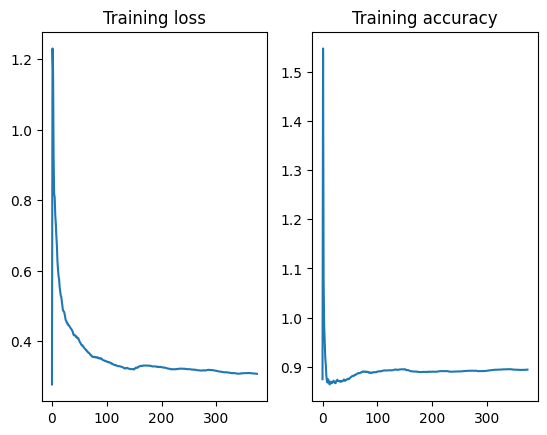

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

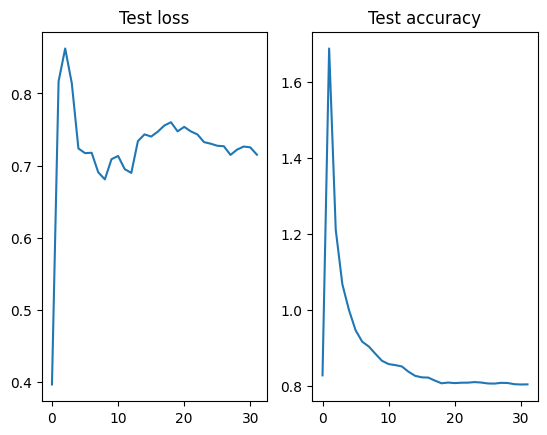

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [ ]:
import copy

def grid_search(train_dataset, cfg, learning_rates=[1e-1, 1e-2, 1e-3], batch_sizes=[32, 64, 128]):
    """
    Grid search over learning rates and batch sizes for MyCNNModel using Trainer.
    Returns the best model, config, and final training loss/accuracy.
    """
    best_model = None
    best_cfg = None
    best_avg_loss = float('inf')
    best_avg_acc = 0.0

    for lr in learning_rates:
        for bs in batch_sizes:

            # Copy config and update
            cfg_current = cfg.copy()
            cfg_current["learning_rate"] = lr
            cfg_current["batch_size"] = bs

            # Initialize model and trainer
            model = MyCNNModel(n_classes=10)
            trainer = Trainer(model, cfg_current)

            # Train model
            train_loss, train_acc = trainer.train(train_dataset)

            # Take final batch values as "average" for this config
            avg_loss = train_loss[-1]
            avg_acc = train_acc[-1]

            # Track best model
            if avg_acc > best_avg_acc or (avg_acc == best_avg_acc and avg_loss < best_avg_loss):
                best_avg_acc = avg_acc
                best_avg_loss = avg_loss
                best_cfg = cfg_current
                best_model = copy.deepcopy(model)  # save model safely

            print(f"LR={lr}, Batch={bs} -> Loss={avg_loss:.4f}, Acc={avg_acc:.4f}")

    print(f"\nBest configuration: lr={best_cfg['learning_rate']}, batch_size={best_cfg['batch_size']}")
    print(f"Final training loss={best_avg_loss:.4f}, accuracy={best_avg_acc:.4f}")

    return best_model, best_cfg, best_avg_loss, best_avg_acc


best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")


Epoch:0 - Avg loss:276.48285 - Avg acc:0.09450: 100%|██████████| 250/250 [00:20<00:00, 12.44it/s]


LR=0.1, Batch=32 -> Loss=276.4828, Acc=0.0945


Epoch:0 - Avg loss:273.07853 - Avg acc:0.10257: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]


LR=0.1, Batch=64 -> Loss=273.0785, Acc=0.1026


Epoch:0 - Avg loss:888.71472 - Avg acc:0.09740: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


LR=0.1, Batch=128 -> Loss=888.7147, Acc=0.0974


Epoch:0 - Avg loss:1.92122 - Avg acc:0.25816: 100%|██████████| 250/250 [00:18<00:00, 13.65it/s]


LR=0.01, Batch=32 -> Loss=1.9212, Acc=0.2582


Epoch:0 - Avg loss:2.35572 - Avg acc:0.10232: 100%|██████████| 125/125 [00:17<00:00,  7.23it/s]


LR=0.01, Batch=64 -> Loss=2.3557, Acc=0.1023


Epoch:0 - Avg loss:2.01588 - Avg acc:0.26802: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


LR=0.01, Batch=128 -> Loss=2.0159, Acc=0.2680


Epoch:0 - Avg loss:1.65763 - Avg acc:0.37287: 100%|██████████| 250/250 [00:20<00:00, 12.35it/s]


LR=0.001, Batch=32 -> Loss=1.6576, Acc=0.3729


Epoch:0 - Avg loss:1.68762 - Avg acc:0.35131: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


LR=0.001, Batch=64 -> Loss=1.6876, Acc=0.3513


Epoch:0 - Avg loss:1.86086 - Avg acc:0.29990: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]

LR=0.001, Batch=128 -> Loss=1.8609, Acc=0.2999

Best configuration: lr=0.001, batch_size=32
Final training loss=1.6576, accuracy=0.3729
Best model achieves 1.66 loss and 37.3% accuracy


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [ ]:
from torchvision import models
from torchvision.models.resnet import resnet18, ResNet18_Weights


loaded_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers to retain pre-trained feature extraction
for param in loaded_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match EuroSAT's 10 classes
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, len(data.classes))

loaded_trainer = Trainer(loaded_model, cfg)

Epoch:2 - Avg loss:0.78376 - Avg acc:0.76253: 100%|██████████| 125/125 [00:40<00:00,  3.10it/s]


Text(0.5, 1.0, 'Training accuracy')

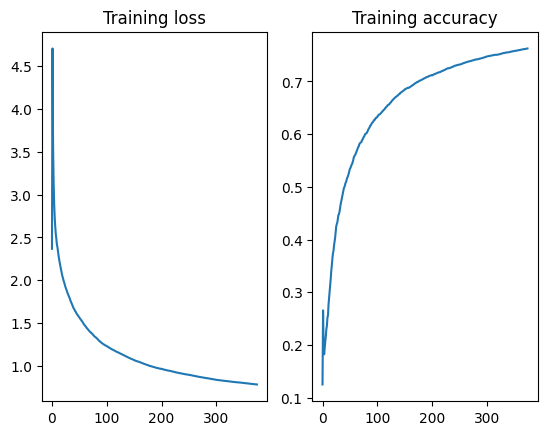

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

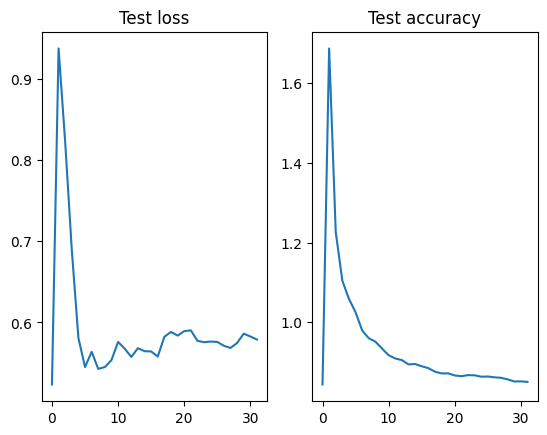

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


In [ ]:
# Load pretrained model again
tuned_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Unfreeze last two layers (layer4 and fc)
for name, param in tuned_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final layer
num_features = tuned_model.fc.in_features
tuned_model.fc = nn.Linear(num_features, len(data.classes))
tuned_model = tuned_model.to(device)

# Train again using the same Trainer
tuned_trainer = Trainer(tuned_model, cfg)
tuned_train_loss, tuned_train_acc = tuned_trainer.train(train_data)
tuned_test_loss, tuned_test_acc = tuned_trainer.test(test_data)

Epoch:2 - Avg loss:0.22650 - Avg acc:0.92856: 100%|██████████| 125/125 [00:02<00:00, 61.88it/s]


We chose to fine tune a pretrained residual network because residual networks are good at balancing accuracy with computational efficiency. The residual help prevent the vanishing gradients and therefore less degredation. We chose the ResNet 18 specifically because its less complex and leads to faster training and lower memory requirements compared to larger Resnet models.

<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             



